# Create radiometric and spatial clusters and classify them with Random Forest

In our notebook `Analyse_Clusters.ipynb` we trained a RF-classifier.<br>
Now we are able to use it. But first we need to do the clustering again.


<b>This Jupyter-Notebook is part of a master thesis with the topic<br>
<i>Analysis of deep learning methods for semantic segmentation of photogrammetric point clouds from aerial images</i><br>
&copy; Markus Hülsen, Matr.-Nr. 6026370<br>
Date: 15.08.2023</b>

## Setting up 3D Python Context
Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import laspy
import os
import pandas as pd
from tqdm.notebook import tqdm 
import random

## Import Data
Data is stored as `LAS`-file. We will use `laspy` to import und convert the data.<br>
First we create a function to import an `LAS`-File and convert them into a Pandas `DataFrame`.

In [2]:
def import_las_to_Dataframe(path):
    with laspy.open(path) as f:
        las = f.read()
    
    # read coordinates from las
    x = np.array(las.x)
    y = np.array(las.y)
    z = np.array(las.z)

    df = pd.DataFrame({'X':x,'Y':y,'Z':z},index=np.arange(len(x)))

    for i in range(3, len(las.point_format.dimensions)):
        dim = las.point_format.dimensions[i].name
        df[dim] = np.array(las[dim])
     
    return df

Express path where the data is stored, that we want to processed. <br>All `las`-Files inside the defined folder will be stored in a list.

In [3]:
# path where the data ist stored
data_path = '../../Daten/Datensatz_H3D/'
# sub-folder which includes different acquisition dates and types like 'DIM_2016', 'DIM_2019', 'DIM_2022', 'ALS2016', ...
data = 'DIM_2022/6 - KMeans 2/classified'

# save files that are in laz-format
lst_files = []
for file in os.listdir(data_path + data):
    
    # Add Label 9 and label 11 to the list
    if file.endswith('.las') or file.endswith('.laz'):
        lst_files.append(data_path + data + '/' + file)
lst_files = sorted(lst_files)
print('Found',len(lst_files),'las-files:')
print(lst_files)

Found 12 las-files:
['../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified554000_5798000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified554000_5799000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified554000_5800000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified554000_5801000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified555000_5798000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified555000_5799000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified555000_5800000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified555000_5801000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified556000_5798000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified556000_5799000.laz', '../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classifie

Use function above to read the point cloud and convert it to pandas DataFrame.

In [4]:
# define file we want to use
las_path = lst_files[10]
las_path

'../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified556000_5800000.laz'

In [5]:
# import data
df = import_las_to_Dataframe(las_path)
df = df.drop('delta_z', axis=1, errors='ignore')

df

,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_veg,count_ground
0,556117.12,5800603.47,69.53,28079,1,3,0,0,8,1,...,27.0,0.866146,-3.131875,0.815199,-3.180062,0.392573,2.0,1.667737,NaN,NaN
1,556115.07,5800602.35,70.08,8749,1,5,0,0,8,1,...,30.0,0.463581,-6.434121,-4.080501,-1.720481,0.577210,2.0,2.279128,NaN,NaN
2,556116.11,5800601.80,70.36,8756,1,4,0,0,8,1,...,18.0,0.217637,0.313609,0.667972,-1.619343,0.010804,2.0,2.533380,NaN,NaN
3,556114.26,5800600.98,69.67,10135,1,4,0,0,8,1,...,13.0,0.683289,-5.341988,-2.381490,-1.065500,0.542996,2.0,1.900700,NaN,NaN
4,556116.69,5800602.63,69.26,9813,1,1,0,0,8,1,...,20.0,0.766677,-5.686312,0.537356,-2.510547,0.444441,2.0,1.413278,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417816,556116.54,5800572.05,68.40,7550,1,5,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450635,NaN,NaN
5417817,556118.40,5800571.82,68.58,7555,1,5,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.647255,NaN,NaN
5417818,556107.76,5800563.85,68.39,7548,1,6,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363830,NaN,NaN
5417819,556117.28,5800572.52,68.50,7550,1,2,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.563784,NaN,NaN


## Datapreparation
Some of the features are not necessary/redudant. We will remove them.

In [6]:
print('Attribute:')
for column in df:
    if len(pd.unique(df[column])) == 1:
        print(str(column) + (25 - len(str(column))) * ' '  + 'contains just a single value and will be returned!')
        df = df.drop(column, axis=1)
    else:
        print(str(column) +  (25 - len(str(column))) * ' '  + 'will be maintained')

df

Attribute:
X                        will be maintained
Y                        will be maintained
Z                        will be maintained
intensity                will be maintained
return_number            contains just a single value and will be returned!
number_of_returns        will be maintained
scan_direction_flag      contains just a single value and will be returned!
edge_of_flight_line      contains just a single value and will be returned!
classification           will be maintained
synthetic                will be maintained
key_point                contains just a single value and will be returned!
withheld                 contains just a single value and will be returned!
scan_angle_rank          contains just a single value and will be returned!
user_data                will be maintained
point_source_id          contains just a single value and will be returned!
gps_time                 contains just a single value and will be returned!
red                      will

,X,Y,Z,intensity,number_of_returns,classification,synthetic,user_data,red,green,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_veg,count_ground
0,556117.12,5800603.47,69.53,28079,3,8,1,107,41984,42240,...,27.0,0.866146,-3.131875,0.815199,-3.180062,0.392573,2.0,1.667737,NaN,NaN
1,556115.07,5800602.35,70.08,8749,5,8,1,150,38912,38656,...,30.0,0.463581,-6.434121,-4.080501,-1.720481,0.577210,2.0,2.279128,NaN,NaN
2,556116.11,5800601.80,70.36,8756,4,8,1,134,15360,18176,...,18.0,0.217637,0.313609,0.667972,-1.619343,0.010804,2.0,2.533380,NaN,NaN
3,556114.26,5800600.98,69.67,10135,4,8,1,107,13056,18944,...,13.0,0.683289,-5.341988,-2.381490,-1.065500,0.542996,2.0,1.900700,NaN,NaN
4,556116.69,5800602.63,69.26,9813,1,8,1,165,14080,15616,...,20.0,0.766677,-5.686312,0.537356,-2.510547,0.444441,2.0,1.413278,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417816,556116.54,5800572.05,68.40,7550,5,2,0,121,9472,13312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450635,NaN,NaN
5417817,556118.40,5800571.82,68.58,7555,5,2,0,151,13824,19200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.647255,NaN,NaN
5417818,556107.76,5800563.85,68.39,7548,6,2,0,174,10496,16896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363830,NaN,NaN
5417819,556117.28,5800572.52,68.50,7550,2,2,0,113,12544,18944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.563784,NaN,NaN


## Point Cloud Filtering

### Reduce area of the Pointcloud
Because the pointcloud contains to many points we will look in area with 100m x 100m.

In [7]:
# Bounding Box
bbox_x1 = df.X.min()
bbox_y1 = df.Y.min()
bbox_x2 = (df.X.max() + df.X.min())
bbox_y2 = (df.Y.max() + df.Y.min())

# Select Point inside of Bounding Box
df_sub = df.loc[(df.X >= bbox_x1) & (df.Y >= bbox_y1) & (df.X <= bbox_x2) & (df.Y <= bbox_y2)]

print('Check Results')
print('X min:', df_sub.X.min(), 'X max:', df_sub.X.max())
print('Y min:', df_sub.Y.min(), 'Y max:', df_sub.Y.max())

df_sub

Check Results
X min: 556000.0 X max: 556999.96
Y min: 5800000.0 Y max: 5800999.74


,X,Y,Z,intensity,number_of_returns,classification,synthetic,user_data,red,green,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_veg,count_ground
0,556117.12,5800603.47,69.53,28079,3,8,1,107,41984,42240,...,27.0,0.866146,-3.131875,0.815199,-3.180062,0.392573,2.0,1.667737,NaN,NaN
1,556115.07,5800602.35,70.08,8749,5,8,1,150,38912,38656,...,30.0,0.463581,-6.434121,-4.080501,-1.720481,0.577210,2.0,2.279128,NaN,NaN
2,556116.11,5800601.80,70.36,8756,4,8,1,134,15360,18176,...,18.0,0.217637,0.313609,0.667972,-1.619343,0.010804,2.0,2.533380,NaN,NaN
3,556114.26,5800600.98,69.67,10135,4,8,1,107,13056,18944,...,13.0,0.683289,-5.341988,-2.381490,-1.065500,0.542996,2.0,1.900700,NaN,NaN
4,556116.69,5800602.63,69.26,9813,1,8,1,165,14080,15616,...,20.0,0.766677,-5.686312,0.537356,-2.510547,0.444441,2.0,1.413278,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417816,556116.54,5800572.05,68.40,7550,5,2,0,121,9472,13312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450635,NaN,NaN
5417817,556118.40,5800571.82,68.58,7555,5,2,0,151,13824,19200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.647255,NaN,NaN
5417818,556107.76,5800563.85,68.39,7548,6,2,0,174,10496,16896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363830,NaN,NaN
5417819,556117.28,5800572.52,68.50,7550,2,2,0,113,12544,18944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.563784,NaN,NaN


### Just consider classes `Not-Ground`
Class 'not ground' is defined by `13`

In [8]:
df_not_ground = df_sub.loc[(df_sub.classification == 13)].drop(['classification', 'delta_z'], axis=1, errors='ignore')
df_not_ground

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_veg,count_ground
3983,556080.69,5800637.91,69.28,8497,7,0,123,17408,13568,11264,...,0.0,0.501625,0.251673,0.689770,-1.399539,0.032408,7.0,1.744765,20.0,1.0
3984,556083.05,5800639.82,68.34,15983,6,0,79,14080,14848,14336,...,0.0,0.759946,0.516671,0.353420,-3.568112,0.080527,7.0,0.826492,24.0,13.0
5301985,556380.20,5800316.30,73.24,10384,1,0,138,33792,22272,23808,...,0.0,0.569943,0.192123,0.736082,0.000000,0.038195,14.0,1.081691,4.0,52.0
5301986,556379.59,5800315.59,73.70,10005,4,0,169,37632,20992,22016,...,0.0,0.699778,0.293565,0.583113,-2.865681,0.067398,14.0,1.543569,6.0,49.0
5301987,556380.63,5800316.17,73.67,9181,2,0,114,33536,22528,24832,...,0.0,0.552609,-15.491795,4.723177,-2.185293,0.402203,14.0,1.509770,4.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402358,556879.55,5800131.45,75.56,8616,3,0,145,7424,13568,15872,...,63.0,0.306031,0.524276,0.447391,-2.125811,0.018838,2.0,2.253057,15.0,0.0
5402359,556879.50,5800132.68,75.31,8889,5,0,140,7424,13568,16640,...,69.0,0.317816,0.545443,0.433027,-3.247951,0.014586,2.0,2.016731,11.0,0.0
5402360,556879.80,5800131.09,75.24,8617,3,0,167,6400,11008,13056,...,59.0,0.303063,0.482694,0.485902,-1.944865,0.020277,2.0,1.915109,16.0,0.0
5402361,556878.77,5800131.89,75.34,8392,4,0,89,7680,14080,15616,...,72.0,0.309862,0.442159,0.532014,-1.761470,0.016309,2.0,2.088569,11.0,0.0


## Update the count-attribute
After we have made another classification with K-Means, we need to update the attributes `count_building`, `count_veg` and `count_ground`.

### Define KD-Tree

In [9]:
from sklearn.neighbors import KDTree

In [10]:
# points
X = df_sub.loc[:,'X':'Z']

#number of nearest neighbors
K=100

kdt = KDTree(X, leaf_size=40, metric='euclidean')
dist, indices = kdt.query(X, k=K, return_distance=True)

print('Indices:\n', indices)
print()
print('Distances:\n', dist)

Indices:
 [[      0 2731404       4 ...     353 2734457      82]
 [      1      11      12 ...     172     278      63]
 [      2     222      64 ... 2734457     173      83]
 ...
 [5417818 5417511 5415297 ... 5417427 5417046 5417109]
 [5417819 5417792 5417801 ... 5417570 5417216 5417306]
 [5417820 5417817 5417781 ... 5417269  739232 5417064]]

Distances:
 [[0.         0.76446059 0.98152942 ... 3.06858273 3.07533738 3.08949834]
 [0.         0.25377155 0.4652956  ... 2.77758888 2.79546061 2.79739164]
 [0.         0.3471311  0.45276926 ... 2.58120127 2.5821309  2.59949995]
 ...
 [0.         0.59084685 0.61983869 ... 2.56454674 2.56972761 2.57017509]
 [0.         0.24738634 0.35213634 ... 2.52065468 2.53073112 2.53246915]
 [0.         0.16155494 0.41158231 ... 2.78793831 2.79073467 2.7992499 ]]


Estimate the positions of the classes 13 and 40

In [11]:
# Estimate position of points with class = 13
position = df_sub.reset_index().loc[(df_sub.reset_index().classification == 13) | (df_sub.reset_index().classification == 40)].index.to_numpy()
position

array([   3983,    3984, 5301985, ..., 5402360, 5402361, 5402362])

Get the labels of the neighboring-points

In [12]:
labels = df_sub.classification.to_numpy()[indices][position]
labels

array([[13,  8, 20, ...,  8,  8,  8],
       [13, 20,  2, ...,  2,  8,  8],
       [13, 13, 13, ...,  2,  2,  8],
       ...,
       [13,  6,  6, ...,  6,  6,  6],
       [13, 20, 13, ...,  6,  6,  6],
       [13, 13, 13, ..., 20,  6,  2]], dtype=uint8)

Count how often the label `vegetation` occurs.

In [13]:
build_count = np.sum(labels == 6, axis=1)

print('Label "building" occurs', build_count, 'in the neighborhoods.')
print(len(build_count))

Label "building" occurs [ 0  0  0 ... 60 73 68] in the neighborhoods.
100380


Count how often the label `building` occurs. 

In [14]:
veg_count = np.sum(labels == 20, axis=1)

print('Label "vegetation" occurs', veg_count, 'in the neighborhoods.')
print(len(veg_count))

Label "vegetation" occurs [21 22  4 ... 16 11 13] in the neighborhoods.
100380


Count how often the label `ground` occurs.

In [15]:
ground_count = np.sum(labels == 2, axis=1)

print('Label "ground" occurs', ground_count, 'in the neighborhoods.')
print(len(veg_count))

Label "ground" occurs [ 1 16 52 ... 13  5  6] in the neighborhoods.
100380


Add results to DataFrame

In [16]:
df_not_ground['count_veg'] = veg_count
df_not_ground['count_building'] = build_count
df_not_ground['count_ground'] = ground_count

df_not_ground.loc[:, ['count_veg', 'count_building', 'count_ground']]

,count_veg,count_building,count_ground
3983,21,0,1
3984,22,0,16
5301985,4,0,52
5301986,8,0,49
5301987,5,0,51
...,...,...,...
5402358,15,64,10
5402359,11,70,5
5402360,16,60,13
5402361,11,73,5


## Cluster by Color with K-Means
First we want to cluster our pointcloud by the color, using the HSV-colorspace.build_count = np.sum(labels == 6, axis=1)

print('Label "building" occurs', build_count, 'in the neighborhoods.')
print(len(build_count))

In [17]:
import colorsys

Get color in RGB, normalize them and change the colorspace

In [18]:
r, g, b = df_not_ground.loc[:, 'red':'blue'].to_numpy().T
r, g ,b = (r/256).astype('uint8'), (g/256).astype('uint8'), (b/256).astype('uint8')
rgb = np.array([r,g,b]).T / 256

hsv_norm = np.apply_along_axis(lambda x: colorsys.rgb_to_hsv(*x), -1, rgb)
hsv_norm

array([[0.0625    , 0.35294118, 0.265625  ],
       [0.38888889, 0.05172414, 0.2265625 ],
       [0.97777778, 0.34090909, 0.515625  ],
       ...,
       [0.55128205, 0.50980392, 0.19921875],
       [0.53225806, 0.50819672, 0.23828125],
       [0.52469136, 0.50943396, 0.20703125]])

Add HSV-Colors to the DataFrame

In [19]:
color = pd.DataFrame(hsv_norm, index=df_not_ground.index, columns=['Hue', 'Saturation', 'Value'])
df_not_ground.loc[:, ['Hue', 'Saturation', 'Value']] = hsv_norm
color.head()

,Hue,Saturation,Value
3983,0.062500,0.352941,0.265625
3984,0.388889,0.051724,0.226562
5301985,0.977778,0.340909,0.515625
5301986,0.989744,0.442177,0.574219
5301987,0.965116,0.328244,0.511719


Seperate the colors in `inside_road` and `outside_road`

In [20]:
color_inside = color.loc[df_not_ground.inside_road == 1]
color_outside = color.loc[(df_not_ground.inside_road != 1)]

Use MinMaxScaler to scale our features.

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
color_inside_scaled = MinMaxScaler().fit_transform(color_inside.to_numpy())
color_inside_scaled

array([[0.97981907, 0.46391753, 0.43842365],
       [0.99180986, 0.60172523, 0.51231527],
       [0.96713114, 0.44668293, 0.43349754],
       ...,
       [0.38174769, 0.12057941, 0.1773399 ],
       [0.35490605, 0.13957177, 0.17241379],
       [0.41753653, 0.17846882, 0.08866995]])

In [23]:
color_outside_scaled = MinMaxScaler().fit_transform(color_outside.to_numpy())
color_outside_scaled

array([[0.06260331, 0.46352941, 0.14746544],
       [0.38953168, 0.06793103, 0.10138249],
       [0.91818182, 0.0354955 , 0.17511521],
       ...,
       [0.55219326, 0.66954248, 0.06912442],
       [0.53313783, 0.66743169, 0.11520737],
       [0.52555862, 0.6690566 , 0.07834101]])

### Implementation of KMeans

In [24]:
K = 6
kmeans_inside = KMeans(n_clusters=K, init='k-means++', random_state = 42)
kmeans_outside = KMeans(n_clusters=K, init='k-means++', random_state = 42)

In [25]:
kmeans_inside.fit(color_inside_scaled)
kmeans_outside.fit(color_outside_scaled)

labels_inside = kmeans_inside.labels_ + K
labels_outside = kmeans_outside.labels_

/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Visulaize a histogram of the clusters, to see how often each cluster occurs.

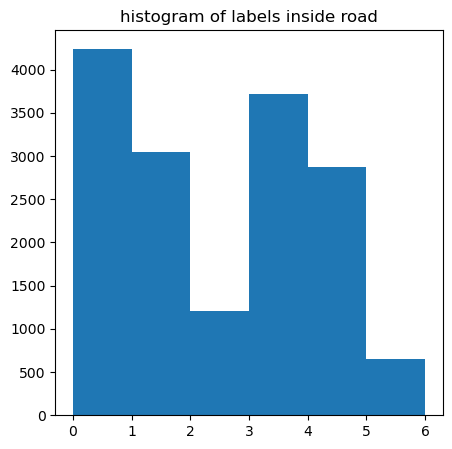

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(labels_inside - K, bins = np.arange(0, K+1))
ax.set_title("histogram of labels inside road")
ax.set_xticks(np.arange(0, K+1))
plt.show()

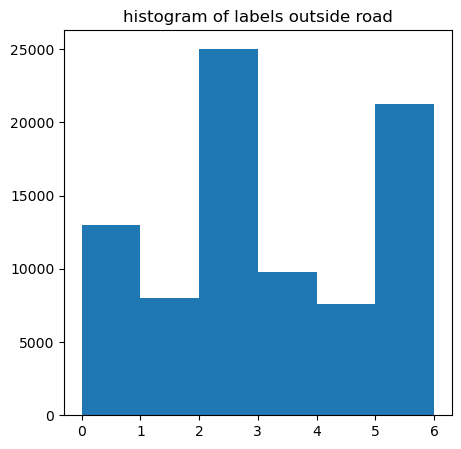

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(labels_outside, bins = np.arange(0, K+1))
ax.set_title("histogram of labels outside road")
ax.set_xticks(np.arange(0, K+1))
plt.show()

Add results to DataFrame

In [28]:
df_not_ground.loc[color_inside.index,'label'] = labels_inside
df_not_ground.loc[color_outside.index,'label'] = labels_outside

print('Existing clusters in DataFrame:\n', sorted(df_not_ground['label'].unique()))

Existing clusters in DataFrame:
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]


Visualize Scatter plot of the KMeans clustering

In [29]:
classes, counts = np.unique(df_not_ground['label'], return_counts=True)

# add labels to the DataFrame
XYZ = df_not_ground.loc[:,['X', 'Y', 'Z', 'label']]
XYZ

,X,Y,Z,label
3983,556080.69,5800637.91,69.28,4.0
3984,556083.05,5800639.82,68.34,0.0
5301985,556380.20,5800316.30,73.24,11.0
5301986,556379.59,5800315.59,73.70,11.0
5301987,556380.63,5800316.17,73.67,11.0
...,...,...,...,...
5402358,556879.55,5800131.45,75.56,2.0
5402359,556879.50,5800132.68,75.31,2.0
5402360,556879.80,5800131.09,75.24,2.0
5402361,556878.77,5800131.89,75.34,2.0


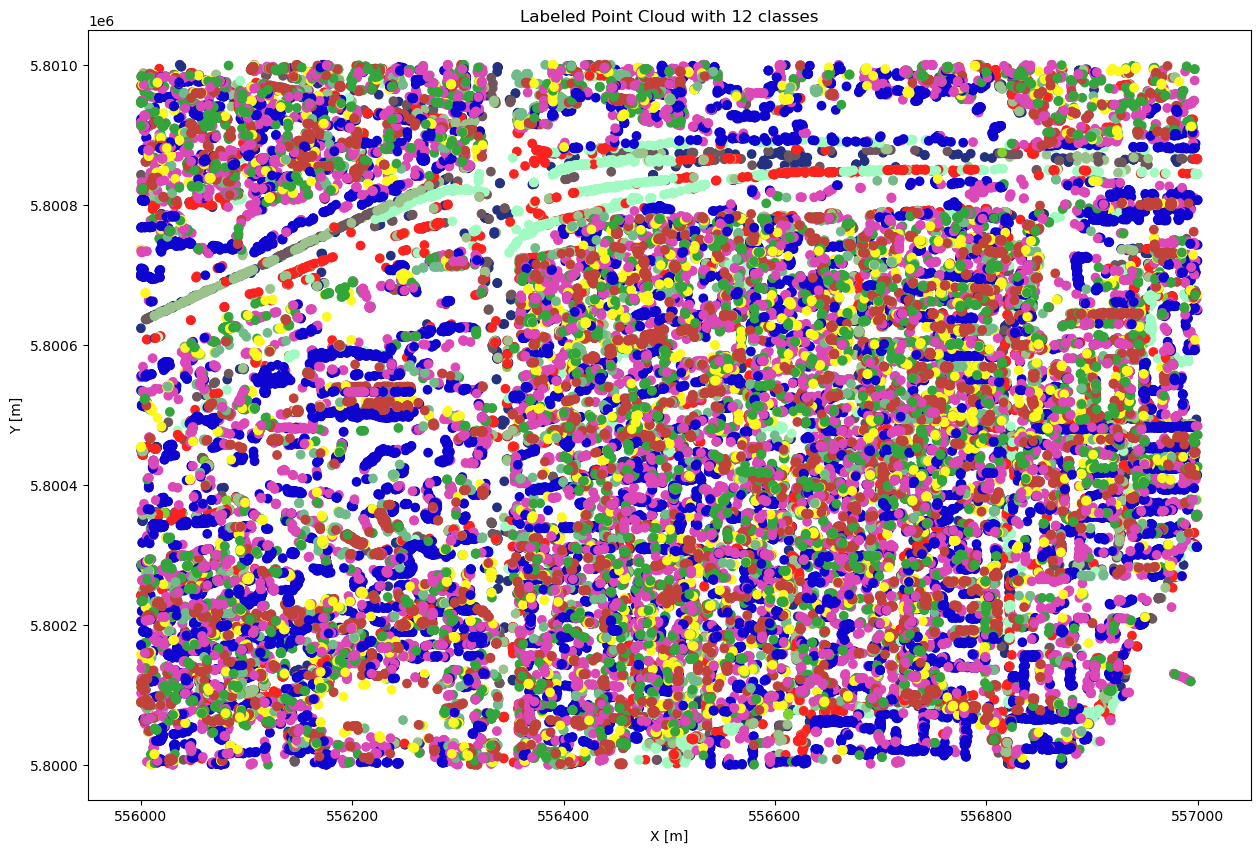

In [30]:
# Define random colors for each class
class_colors = {c: f'#{random.randint(0, 0xFFFFFF):06x}' for c in classes}

# Set the figure size
plt.figure(figsize=(15, 10))  # Adjust the width and height as desired

# Plot the points with colors corresponding to their classes
plt.scatter(XYZ['X'], XYZ['Y'], c=XYZ['label'].map(class_colors))
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Labeled Point Cloud with ' + str(len(classes)) + ' classes')
plt.show()

## Implementation of DBScan

Get unique labels of KMeans clustering

In [31]:
labels_kmeans = sorted(XYZ.label.unique())
labels_kmeans

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

Define export path

In [32]:
file = las_path.split('/')[-1].replace('.las', '').replace('.laz', '')
path = (data_path + data).replace('/6 - KMeans 2/classified', '/7 - DBScan/')
path

'../../Daten/Datensatz_H3D/DIM_2022/7 - DBScan/'

Function to export a DataFrame as las-file.

In [33]:
def save_df_to_las(df, path):
    
    header = laspy.LasHeader(point_format=3, version="1.2")
    
    atts = []
    for dim in header.point_format.dimensions:
        atts.append(dim.name)
    
    for dim in df.columns:
        if dim not in atts:
            header.add_extra_dim(laspy.ExtraBytesParams(name=dim, type=np.float32))
    
    las_new = laspy.LasData(header)

    las_new.x = df.X.to_numpy()
    las_new.y = df.Y.to_numpy()
    las_new.z = df.Z.to_numpy()
    
    for col in df.loc[:,'intensity':].columns:
        las_new[col] = df[col].to_numpy()
    
    las_new.write(path)
    print('created new las file', path)

First lets try DBScan on the first cluster and visualize the results.

Number of noise points: 4442


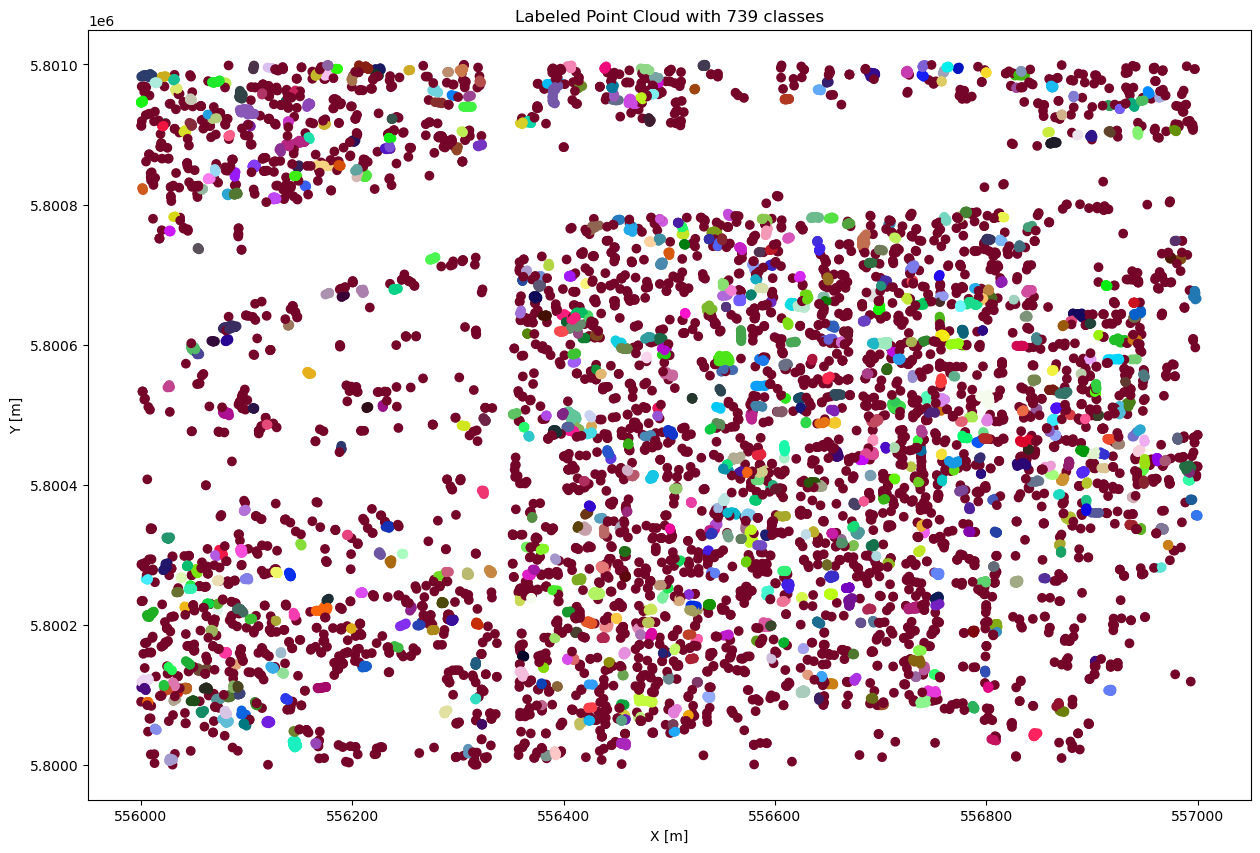

In [34]:
X = XYZ.loc[XYZ.label == 0, 'X':'Z']
clustering = DBSCAN(eps=3.8, min_samples=5).fit(X)
cluster = clustering.labels_
classes, counts = np.unique(cluster, return_counts=True)

print('Number of noise points:',counts[0])
# add labels to the DataFrame
X['class'] = cluster

# Define random colors for each class
class_colors = {c: f'#{random.randint(0, 0xFFFFFF):06x}' for c in classes}

# Set the figure size
plt.figure(figsize=(15, 10))  # Adjust the width and height as desired

# Plot the points with colors corresponding to their classes
plt.scatter(X['X'], X['Y'], c=X['class'].map(class_colors))
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Labeled Point Cloud with ' + str(len(classes)) + ' classes')
plt.show()

if there are `NaN` values inside of the attribute `inside_road`, replace them with 0

In [35]:
df_not_ground.loc[df_not_ground.inside_road.isna(),'inside_road'] = 0
df_not_ground[df_not_ground.isna().any(axis=1)]

,X,Y,Z,intensity,number_of_returns,synthetic,user_data,red,green,blue,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_veg,count_ground
5301995,556168.76,5800219.40,73.28,8370,5,0,118,31488,29952,30464,...,0,0.371700,-6.563716,0.836586,0.477907,0.439945,11.0,0.776645,19,55
5302007,556347.72,5800785.27,72.14,25919,6,0,86,29952,34816,36352,...,0,3.041186,0.613899,0.271840,NaN,0.076155,7.0,5.599176,34,64
5302009,556067.70,5800796.29,65.02,16205,6,0,80,33024,39680,39936,...,0,0.322049,0.752323,0.239384,NaN,0.006603,7.0,0.327275,12,82
5302017,556327.21,5800955.51,66.41,9917,3,0,150,33536,39936,41216,...,0,0.786928,0.599708,0.342560,NaN,0.039596,7.0,0.285200,15,82
5302087,556572.84,5800543.44,78.02,14804,7,0,126,36352,37632,38400,...,0,3.508815,0.569959,0.249042,NaN,0.112349,7.0,7.862463,29,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402102,556926.40,5800936.36,68.52,14959,1,0,124,27136,32768,29696,...,62,0.963619,0.598539,0.221013,-1.964901,0.114070,0.0,3.245234,18,12
5402104,556926.00,5800936.40,68.49,14818,3,0,75,26112,32000,28928,...,69,0.870994,0.557720,0.270188,-1.670911,0.106600,0.0,3.208084,17,6
5402161,556780.26,5800788.45,78.80,16166,2,0,143,16128,17408,18432,...,57,3.387683,0.964009,-0.262493,NaN,0.223672,0.0,12.760914,17,0
5402316,556843.35,5800459.88,73.51,14982,5,0,149,8192,13568,16896,...,66,1.366059,-0.406176,1.261275,-6.561934,0.056800,2.0,0.874029,23,0


## Load Random Forest Model
Now that we have our Clusters we want to predict the label of each cluster with the Random Forest Model, we trained in our notebook `Analyse_Clusters.ipynb`. 

In [36]:
import joblib

Import Random Forest Model

In [37]:
rf = joblib.load('random_forest.joblib')

Function to calculate the neccesary statistics.

In [38]:
def calc_statistics(df_cluster, index):
    # calculate mean
    mean = df_cluster.mean()
    df_mean = mean.rename(index).to_frame().T.add_prefix('mean_')
    
    # calculate standarddeviation
    std = df_cluster.std(axis=0)
    df_std= std.rename(index).to_frame().T.add_prefix('std_')
    
    # concat mean and std
    df_statistics = pd.concat([df_mean, df_std], axis=1)
    
    # count number of point 
    df_statistics['num_points'] = len(df_cluster)
    
    return df_statistics

## DBScan and Random Forest Classification

Use DBScan for every color-cluster to get euclidian clusters in a metric room.

We create a dict to save every geometric cluster inside of a radiometric cluster. 

For example:<br>
<ul>
    <li>{kmeans cluster1:</li>
    <ul>
        <li>{dbscan cluster -1: </li>
            <ul>
                <li>{points: DataFrame with Points,</li>
                <li>classification: string with classification,</li>
                <li>probability: list with probabilitys}</li>
            </ul>
        <li>dbscan cluster 0: </li>
            <ul>
                <li>{points: DataFrame with Points,</li>
                <li>classification: string with classification,</li>
                <li>probability: list with probabilitys}</li>
            </ul>
        <li>...}</li>
    </ul>
    <li>kmeans cluster2:</li>
    <ul>
        <li>{dbscan cluster -1: </li>
            <ul>
                <li>{points: DataFrame with Points,</li>
                <li>classification: string with classification,</li>
                <li>probability: list with probabilitys}</li>
            </ul>
        <li>dbscan cluster 0: </li>
            <ul>
                <li>{points: DataFrame with Points,</li>
                <li>classification: string with classification,</li>
                <li>probability: list with probabilitys}</li>
            </ul>
        <li>...}</li>
    </ul>
    <li>...}</li>
</ul>

In [39]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [40]:
master_dict = {}

for cluster in tqdm(labels_kmeans):
    X = XYZ.loc[XYZ.label == cluster, 'X':'Z']
    clustering = DBSCAN(eps=3.8, min_samples=5).fit(X)
    labels = clustering.labels_
    X.loc[:,'cluster'] = labels
    
    cluster_dict = {}
    unique_labels = np.unique(labels)
    for label in unique_labels:
        df_cluster = df_not_ground.loc[X.loc[X.cluster == label].index]
        df_cluster['dbscan_cluster'] = label
        
        if label == -1:
            cluster_dict[str(label)] = {'points': df_cluster, 
                                   'classification': 'noise', 
                                   'probabilitys': {'noise': None}
                                  }
        else:
            stats = calc_statistics(df_cluster, str(cluster) + '_' + str(label))
            stats = stats[['mean_z_to_dem', 'mean_std_z', 'mean_count_building', 'mean_Saturation', 'mean_count_veg', 'std_Hue', 'mean_Value',
                             'std_count_building', 'std_std_z', 'mean_Hue']]
            if stats.isnull().values.any():
                print('cluster', cluster, 'label', label, 'DataFrame:', stats)
            pred_class = rf.predict(stats)
            prob = rf.predict_proba(stats)
            cluster_dict[str(label)] = {'points': df_cluster, 
                                   'classification': pred_class, 
                                   'probabilitys': {'building': prob[0][0], 'ground': prob[0][1], 'humanmade':prob[0][2], 'vegetation':prob[0][3] }}
    
    master_dict[cluster] = cluster_dict

len(master_dict)

  0%|          | 0/12 [00:00<?, ?it/s]

12

In [41]:
for key in master_dict.keys():
    print('number of clusters from DBScan:', len(master_dict[key].keys()))

number of clusters from DBScan: 739
number of clusters from DBScan: 373
number of clusters from DBScan: 1008
number of clusters from DBScan: 473
number of clusters from DBScan: 432
number of clusters from DBScan: 1318
number of clusters from DBScan: 255
number of clusters from DBScan: 200
number of clusters from DBScan: 58
number of clusters from DBScan: 165
number of clusters from DBScan: 177
number of clusters from DBScan: 31


In [42]:
for i, key in enumerate(master_dict[0].keys()):
    if key != '-1':
        print('cluster', key, ': ', len(master_dict[0][key]['points']), 
              'points\tlabel:', master_dict[0][key]['classification'][0], 
              '\tprobability:', master_dict[0][key]['probabilitys'][master_dict[0][key]['classification'][0]])
        if i > 20:
            print('...')
            break

cluster 0 :  18 points	label: vegetation 	probability: 0.55
cluster 1 :  10 points	label: building 	probability: 0.49
cluster 2 :  12 points	label: vegetation 	probability: 0.5
cluster 3 :  19 points	label: humanmade 	probability: 0.45
cluster 4 :  12 points	label: humanmade 	probability: 0.54
cluster 5 :  8 points	label: vegetation 	probability: 0.49
cluster 6 :  15 points	label: vegetation 	probability: 0.63
cluster 7 :  10 points	label: vegetation 	probability: 0.65
cluster 8 :  9 points	label: vegetation 	probability: 0.41
cluster 9 :  9 points	label: humanmade 	probability: 0.4
cluster 10 :  28 points	label: building 	probability: 0.38
cluster 11 :  11 points	label: humanmade 	probability: 0.46
cluster 12 :  27 points	label: vegetation 	probability: 0.71
cluster 13 :  6 points	label: vegetation 	probability: 0.71
cluster 14 :  11 points	label: humanmade 	probability: 0.51
cluster 15 :  18 points	label: vegetation 	probability: 0.4
cluster 16 :  11 points	label: humanmade 	probabil

Define output folder

In [43]:
file = las_path.split('/')[-1].replace('.las', '').replace('.laz', '')
path = (data_path + data).replace('/6 - KMeans 2', '/7 - DBScan')
path + '/'+ file

'../../Daten/Datensatz_H3D/DIM_2022/7 - DBScan/classified/classified556000_5800000'

Generate new folder, if not already existing

In [44]:
if not os.path.isdir(path):
    os.makedirs(path)
    print('created new folder', path)
else:
    print(path, 'already exists')

../../Daten/Datensatz_H3D/DIM_2022/7 - DBScan/classified already exists


Now iterate throw the Dictionary and save the result to our pointcloud.

In [45]:
print('Not classified points befor Iteration:', len(df.loc[df.classification == 13]))
probs = []
# iterate throw every kmeans clutser
for i, key_kmeans in enumerate(master_dict.keys()):
    
    # iterate throw every dbscan clutser
    for j, key_dbscan in enumerate(master_dict[key_kmeans].keys()):
        
        # ignore label '-1' which are noise points
        if key_dbscan != '-1':
            
            # get the points of cluster
            df_points = master_dict[key_kmeans][key_dbscan]['points']
            
            # get classification of cluster
            classi = master_dict[key_kmeans][key_dbscan]['classification'][0]
            
            # get probability
            prob = master_dict[key_kmeans][key_dbscan]['probabilitys'][classi]
            probs.append(prob)
            
            # change classification in global DataFrame with all points
            if classi == 'humanmade':
                df.loc[df_points.index, 'classification'] = 40
            elif classi == 'ground':
                df.loc[df_points.index, 'classification'] = 2
            elif classi == 'building':
                df.loc[df_points.index, 'classification'] = 6
            elif classi == 'vegetation':
                df.loc[df_points.index, 'classification'] = 20
            
# print('kmeans cluster:',key_kmeans, '\tdbscan cluster:', key_dbscan, '\tClassification:', classi)
print('Not classified points after Iteration:', len(df.loc[df.classification == 13]))
df.loc[df.classification == 13]

Not classified points befor Iteration: 100380
Not classified points after Iteration: 23347


,X,Y,Z,intensity,number_of_returns,classification,synthetic,user_data,red,green,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_veg,count_ground
3983,556080.69,5800637.91,69.28,8497,7,13,0,123,17408,13568,...,0.0,0.501625,0.251673,0.689770,-1.399539,0.032408,7.0,1.744765,20.0,1.0
3984,556083.05,5800639.82,68.34,15983,6,13,0,79,14080,14848,...,0.0,0.759946,0.516671,0.353420,-3.568112,0.080527,7.0,0.826492,24.0,13.0
5301993,556352.53,5800120.02,75.21,8930,5,13,0,118,33024,32768,...,0.0,0.224743,0.108430,0.867805,-0.823647,0.012408,14.0,0.660952,0.0,89.0
5301995,556168.76,5800219.40,73.28,8370,5,13,0,118,31488,29952,...,0.0,0.371700,-6.563716,0.836586,0.477907,0.439945,14.0,0.776645,12.0,55.0
5301996,556079.25,5800361.10,71.14,8731,5,13,0,151,36096,34560,...,0.0,0.368559,-27.004614,5.860380,-0.664193,0.432937,14.0,0.584599,10.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402278,556588.93,5800639.00,71.91,14852,3,13,0,115,6912,12288,...,73.0,1.469641,0.897795,-0.417860,-4.620150,0.320578,2.0,3.128827,10.0,0.0
5402294,556421.28,5800631.40,70.28,9275,1,13,0,67,24064,23808,...,61.0,0.879746,-10.607666,4.264953,-1.806948,0.368049,2.0,1.032766,4.0,28.0
5402315,556939.37,5800661.01,71.25,16246,6,13,0,135,8704,14336,...,49.0,1.207429,-2.718349,-2.553955,-5.262796,0.570694,2.0,3.492157,5.0,0.0
5402319,556844.18,5800461.95,74.23,8336,1,13,0,127,51456,52224,...,66.0,0.310288,0.413816,0.567492,-2.877082,0.011647,2.0,1.757846,16.0,0.0


Show a histogram of the reached probabilitys.

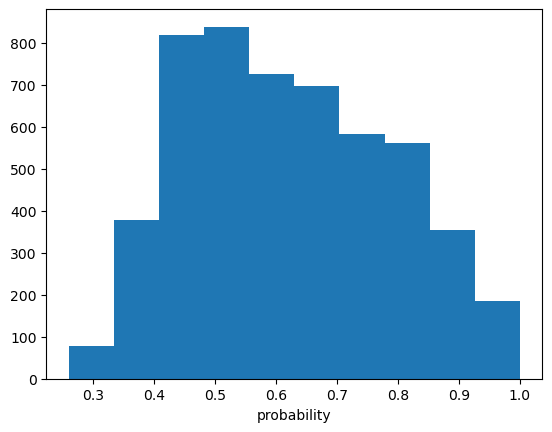

In [46]:
plt.hist(probs)
plt.xlabel('probability')
plt.show()

## Handle noise points
To handle the noise points, we will look at the neighboring points.

In [47]:
df.inside_road = df.inside_road.fillna(0)
df_noise = df.loc[df.classification == 13, ['count_veg', 'count_building', 'count_ground']]
df_noise

,count_veg,count_building,count_ground
3983,20.0,0.0,1.0
3984,24.0,0.0,13.0
5301993,0.0,0.0,89.0
5301995,12.0,0.0,55.0
5301996,10.0,0.0,37.0
...,...,...,...
5402278,10.0,73.0,0.0
5402294,4.0,61.0,28.0
5402315,5.0,49.0,0.0
5402319,16.0,66.0,0.0


In [48]:
df_noise['prob_veg'] = df_noise.count_veg / df_noise.sum(axis=1)
df_noise['prob_building'] = df_noise.count_building / df_noise.sum(axis=1)
df_noise['prob_ground'] = df_noise.count_ground / df_noise.sum(axis=1)
df_noise

,count_veg,count_building,count_ground,prob_veg,prob_building,prob_ground
3983,20.0,0.0,1.0,0.952381,0.000000,0.045553
3984,24.0,0.0,13.0,0.648649,0.000000,0.345298
5301993,0.0,0.0,89.0,0.000000,0.000000,1.000000
5301995,12.0,0.0,55.0,0.179104,0.000000,0.818707
5301996,10.0,0.0,37.0,0.212766,0.000000,0.783686
...,...,...,...,...,...,...
5402278,10.0,73.0,0.0,0.120482,0.878243,0.000000
5402294,4.0,61.0,28.0,0.043011,0.655611,0.298830
5402315,5.0,49.0,0.0,0.092593,0.905854,0.000000
5402319,16.0,66.0,0.0,0.195122,0.802967,0.000000


In [49]:
df_noise.loc[df_noise.prob_veg > 0.5, 'classification'] = 20
df_noise.loc[df_noise.prob_building > 0.5, 'classification'] = 6
df_noise.loc[df_noise.prob_ground > 0.5, 'classification'] = 2
df_noise

,count_veg,count_building,count_ground,prob_veg,prob_building,prob_ground,classification
3983,20.0,0.0,1.0,0.952381,0.000000,0.045553,20.0
3984,24.0,0.0,13.0,0.648649,0.000000,0.345298,20.0
5301993,0.0,0.0,89.0,0.000000,0.000000,1.000000,2.0
5301995,12.0,0.0,55.0,0.179104,0.000000,0.818707,2.0
5301996,10.0,0.0,37.0,0.212766,0.000000,0.783686,2.0
...,...,...,...,...,...,...,...
5402278,10.0,73.0,0.0,0.120482,0.878243,0.000000,6.0
5402294,4.0,61.0,28.0,0.043011,0.655611,0.298830,6.0
5402315,5.0,49.0,0.0,0.092593,0.905854,0.000000,6.0
5402319,16.0,66.0,0.0,0.195122,0.802967,0.000000,6.0


In [50]:
df.loc[df_noise.index, 'classification'] = df_noise.classification
df.loc[df.classification == 13]

,X,Y,Z,intensity,number_of_returns,classification,synthetic,user_data,red,green,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_veg,count_ground


## Save results
Now safe the DataFrame with the new classification

Change classification `40` because the max. value of classification of an laz-file is 31.

In [51]:
df.loc[df.classification == 40, 'classification'] = 31
df.loc[df.classification == 31]

,X,Y,Z,intensity,number_of_returns,classification,synthetic,user_data,red,green,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_veg,count_ground
5301985,556380.20,5800316.30,73.24,10384,1,31.0,0,138,33792,22272,...,0.0,0.569943,0.192123,0.736082,0.000000,0.038195,14.0,1.081691,4.0,52.0
5301986,556379.59,5800315.59,73.70,10005,4,31.0,0,169,37632,20992,...,0.0,0.699778,0.293565,0.583113,-2.865681,0.067398,14.0,1.543569,6.0,49.0
5301987,556380.63,5800316.17,73.67,9181,2,31.0,0,114,33536,22528,...,0.0,0.552609,-15.491795,4.723177,-2.185293,0.402203,14.0,1.509770,4.0,51.0
5301988,556381.79,5800315.87,73.25,8998,7,31.0,0,161,31488,25344,...,0.0,0.504703,-24.219461,8.981267,-1.812186,0.382456,14.0,1.105438,0.0,63.0
5301989,556381.79,5800315.25,73.26,8987,3,31.0,0,128,35072,25344,...,0.0,0.604459,-20.849136,5.307809,-2.589128,0.419932,14.0,1.144458,4.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5397083,556520.28,5800186.02,74.73,8414,4,31.0,0,131,30976,28672,...,58.0,0.710379,0.218037,0.715529,-0.730509,0.035941,2.0,0.526464,5.0,20.0
5397085,556519.65,5800186.01,74.65,8415,1,31.0,0,127,26880,24320,...,56.0,0.694984,-7.781477,1.763728,-0.544337,0.417742,2.0,0.441164,8.0,20.0
5397090,556518.91,5800185.98,74.62,8481,2,31.0,0,139,27904,28160,...,50.0,0.726423,0.873785,-0.448418,-0.625856,0.337851,2.0,0.420281,12.0,21.0
5397091,556520.22,5800186.02,74.58,8632,2,31.0,0,128,23296,25856,...,57.0,0.706044,-10.491624,2.033520,-0.678425,0.430898,2.0,0.375945,6.0,20.0


In [52]:
save_df_to_las(df, path +'/' + file + '.laz')

created new las file ../../Daten/Datensatz_H3D/DIM_2022/7 - DBScan/classified/classified556000_5800000.laz


In [53]:
def make_notification():
    os.system('notify-send "JupyterLab" "Finished with code!"')

In [54]:
make_notification()